# Multi Scale Network Analysis of Flight Data

The provided data contains information about the Airports with their geo-coordinates, and the flights data for a single month. For this report we will focus on the Countries: USA, UK, China, Australia and only on internal flight data. 

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Preliminary Data Cleaning and Pre-processing

In [83]:
import pandas as pd 
import os 
import numpy as np


- Found corrupt file entry in line number 8864 of Airports.csv for "Sim��_��__��_��___��_��__��_��_____n Bol��_��__��_��___��_��__��_��_____var International,Venezuela,10.599444,-66.9825" , manually corrected the file entry to "

In [84]:
# Data Files
data_dir = "/home/julian/git-repo/juliangdz/Multi-Scale-Network-Analysis-of-Flight-Data/data"
airport_dataframe = pd.read_csv(os.path.join(data_dir,'Airports.csv'))
flights_dataframe = pd.read_excel(os.path.join(data_dir,r'Flight Data.xlsx'))

In [85]:
airport_dataframe.head()

,id,label,country,Lat,Lon
0,BIN,Bamyan,Afghanistan,34.800000,67.816667
1,BST,Lashkar Gah,Afghanistan,31.582998,64.360000
2,CCN,Chaghcharan,Afghanistan,34.516701,65.250001
3,DAZ,Darwaz,Afghanistan,38.466667,70.883333
4,FAH,Farah,Afghanistan,32.391730,62.096819


In [86]:
flights_dataframe.head()

,Source,Source City,Source Country,Target,Target City,Target Country,Weight
0,FNC,Funchal,Portugal,PXO,Porto Santo,Portugal,9864
1,PXO,Porto Santo,Portugal,FNC,Funchal,Portugal,9864
2,AEP,Buenos Aires,Argentina,MVD,Montevideo,Uruguay,1463
3,MVD,Montevideo,Uruguay,AEP,Buenos Aires,Argentina,1463
4,AEP,Buenos Aires,Argentina,ROS,Rosario (AR),Argentina,2261


In [87]:
airport_dataframe[airport_dataframe[['Lon']].isna().any(axis=1)].shape[0]

0

In [88]:
airport_dataframe.describe()

,Lat,Lon
count,9033.000000,9033.000000
mean,21.395779,1.495902
std,28.947515,95.180262
min,-54.933302,-178.150000
25%,-3.043611,-80.266667
50%,28.000000,5.151667
75%,44.475798,89.050000
max,82.500000,179.883333


In [89]:
flights_dataframe[flights_dataframe[['Weight']].isna().any(axis=1)].shape[0]

0

In [90]:
flights_dataframe.describe()

,Weight
count,60470.000000
mean,4054.854556
std,5983.344629
min,0.000000
25%,725.000000
50%,2100.000000
75%,4805.000000
max,155588.000000


- Check if Any Airports Flights Dataframe Not seen in Airports Dataframe - This will lead to Missing Geo Information

In [91]:
flights_dataframe[~flights_dataframe['Source'].isin(airport_dataframe['id'])].shape

(152, 7)

In [92]:
flights_dataframe[~flights_dataframe['Target'].isin(airport_dataframe['id'])].shape

(154, 7)

### Data Preprocessing


- Found Discrepencies in Country column for Airports.csv . Will proceed to correct the discrepencies observed using the Information from Flights Data excel by matching the Source and Source Country with the ID of the Airports.csv to correct the Country 

In [93]:
def modify_country_information_based_on_infocus_countries(flights_df:pd.DataFrame,airports_df:pd.DataFrame,infocus_countries:dict):
    flights_df = flights_df.copy()
    airports_df = airports_df.copy()
    
    for key, value in infocus_countries.items():
        for country in value:
            flights_df.loc[flights_df['Source Country'] == country, 'Source Country'] = key
            flights_df.loc[flights_df['Target Country'] == country, 'Target Country'] = key
            airports_df.loc[airports_df['country'] == country, 'country'] = key

    return flights_df, airports_df

In [94]:
in_focus_countries = {
    "USA":["United States","USA"],
    "China":["China"],
    "UK":["United Kingdom","UK"],
    "Australia":["Australia"]
}
modifed_flight_df,modified_airport_df = modify_country_information_based_on_infocus_countries(flights_dataframe,airport_dataframe,in_focus_countries)

- Filter the Dataframe to only include for Countries - US, UK, China, Australia
- Filter for Domestic Flights Only 

In [95]:
def get_domestic_flights_for_countries(flights_df:pd.DataFrame,in_focus_countries:dict):
    # Filter for only In-Focus Countries
    _countries_list = list(in_focus_countries.keys())
    domestic_flights_list = []
    for country in _countries_list:
        domestic_flights = flights_df[(flights_df['Source Country']==country)&(flights_df['Target Country']==country)]
        domestic_flights_df = domestic_flights_list.append(domestic_flights)
    domestic_flights_df = pd.concat(domestic_flights_list,ignore_index=True)
    return domestic_flights_df

In [96]:
domestic_flights_dataframe = get_domestic_flights_for_countries(modifed_flight_df,in_focus_countries)
domestic_flights_dataframe.head()

,Source,Source City,Source Country,Target,Target City,Target Country,Weight
0,SOV,Seldovia,USA,KEB,Nanwalek,USA,144
1,HOM,Homer,USA,SOV,Seldovia,USA,184
2,SOV,Seldovia,USA,HOM,Homer,USA,40
3,PGM,Port Graham,USA,HOM,Homer,USA,144
4,KEB,Nanwalek,USA,PGM,Port Graham,USA,144


- Using the "id" field in airports_dataframe add the "Lat" and "Lon" information in the Flights Dataframe for both Source and Target 

In [97]:
def validate_and_merge_data_corrected(flight_data, airport_data):
    """
    Corrected function to validate and merge flight data with airport data to include geographical coordinates.
    Adjusted to handle the correct column names for latitude and longitude.

    Parameters:
    flight_data (DataFrame): The flight data DataFrame.
    airport_data (DataFrame): The airport data DataFrame.

    Returns:
    DataFrame: Merged flight data with geographical coordinates.
    """
    # Adjusting column names for latitude and longitude
    airport_data = airport_data.rename(columns={'Lat ': 'Lat', 'Lon': 'Lon'})

    # Checking for mismatches or missing data in airport IDs
    missing_source_ids = flight_data[~flight_data['Source'].isin(airport_data['id'])]
    missing_target_ids = flight_data[~flight_data['Target'].isin(airport_data['id'])]

    # Merging flight data with airport data to include coordinates
    merged_data = flight_data.merge(
        airport_data[['id', 'Lat', 'Lon']], left_on='Source', right_on='id', how='left'
    ).rename(columns={'Lat': 'Source Lat', 'Lon': 'Source Lon'}).drop('id', axis=1)

    merged_data = merged_data.merge(
        airport_data[['id', 'Lat', 'Lon']], left_on='Target', right_on='id', how='left'
    ).rename(columns={'Lat': 'Target Lat', 'Lon': 'Target Lon'}).drop('id', axis=1)

    return merged_data, missing_source_ids, missing_target_ids


def data_integrity_checks(merged_data):
    # Identifying rows with missing coordinates
    missing_coordinates = merged_data[merged_data[['Source Lat', 'Source Lon', 'Target Lat', 'Target Lon']].isna().any(axis=1)]

    # Counting the number of missing coordinate entries
    missing_count = missing_coordinates.shape[0]

    # Checking for duplicates in the flight data
    duplicates_count = merged_data.duplicated(subset=['Source', 'Target']).sum()

    # Checking for any anomalies in flight weights (e.g., negative values or extremely high values)
    weight_issues = merged_data[merged_data['Weight'] <= 0]

    # Counting the number of weight issues
    weight_issues_count = weight_issues.shape[0]

    return missing_count, duplicates_count, weight_issues_count


In [98]:
merged_flights_data_corrected, missing_source_ids_corrected, missing_target_ids_corrected = validate_and_merge_data_corrected(domestic_flights_dataframe, modified_airport_df)
data_integrity_checks(merged_flights_data_corrected)

(49, 9620, 0)

- Found 49 Airports with Missing Lat and Lon Information in the Merged Dataframe. Will proceed to correct this using the IATA.csv 

In [99]:
missing_coordinates = merged_flights_data_corrected[merged_flights_data_corrected[['Source Lat', 'Source Lon', 'Target Lat', 'Target Lon']].isna().any(axis=1)]
missing_coordinates.head()

,Source,Source City,Source Country,Target,Target City,Target Country,Weight,Source Lat,Source Lon,Target Lat,Target Lon
82,HYL,Hollis,USA,KLW,Klawock,USA,434,NaN,NaN,55.550000,-133.10
83,KLW,Klawock,USA,HYL,Hollis,USA,434,55.550000,-133.100000,NaN,NaN
84,HYL,Hollis,USA,KTN,Ketchikan,USA,434,NaN,NaN,55.333333,-131.65
85,KTN,Ketchikan,USA,HYL,Hollis,USA,434,55.333333,-131.650000,NaN,NaN
1080,DFW,Dallas/Fort Worth,USA,ILE,Killeen,USA,6150,32.896944,-97.038056,NaN,NaN



To fix and correct this we use the iata.csv as reference guide to help fix our missing and inaccurate geo coordinates

IATA/ICAO List
This list contains the airport codes of [IATA airport code](https://en.wikipedia.org/wiki/International_Air_Transport_Association_airport_code) and [ICAO airport code](https://en.wikipedia.org/wiki/International_Civil_Aviation_Organization_airport_code) grouped based on the country code (ISO3166-1) and region name (ISO3166-2) supported in IP2Location geolocation database.


|Field Name|Description|
|---|---|
|country_code|Two-character country code based on ISO 3166.|
|region_name|Region or state name.|
|iata|Three-character code of IATA airport code.|
|icao|Four-character code of ICAO airport code.|
|airport|Airport name.|
|latitude|Latitude of the airport.|
|longitude|Longitude of the airport.|



The IATA/ICAO list data is licensed under [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/). It is free for personal or commercial use with attribution required by mentioning the use of this data as follows,
**This site or product includes IATA/ICAO List data available from <a href="https://www.ip2location.com">http://www.ip2location.com</a>.**

IATA is a registered trademark of International Air Transport Association.   
ICAO is a registered trademark of International Civil Aviation Organization.   
All other product names mentioned on this repository may be trademarks or registered trademarks of their respective companies.

In [100]:
reference_airports_dataframe = pd.read_csv(os.path.join(data_dir,'iata_icao.csv'))
reference_airports_dataframe.head()

,country_code,region_name,iata,icao,airport,latitude,longitude
0,AE,Ash Shariqah,SHJ,OMSJ,Sharjah International Airport,25.3286,55.5172
1,AE,Abu Zaby,AZI,OMAD,Al Bateen Executive Airport,24.4283,54.4581
2,AE,Al Fujayrah,FJR,OMFJ,Fujairah International Airport,25.1122,56.3240
3,AE,Abu Zaby,XSB,OMBY,Sir Bani Yas Airport,24.2836,52.5803
4,AE,Ra's al Khaymah,RKT,OMRK,Ras Al Khaimah International Airport,25.6135,55.9388


In [101]:
def fix_geo_coordinates_for_airports(routes_df, iata_df):
    # Create a copy of the DataFrame to avoid modifying the original one
    routes_df = routes_df.copy()

    # Joining the DataFrames for Source
    source_df = pd.merge(routes_df, iata_df[['iata', 'latitude', 'longitude']], left_on='Source', right_on='iata', how='left')
    source_df.rename(columns={'latitude': 'new_source_lat', 'longitude': 'new_source_lon'}, inplace=True)

    # Joining the DataFrames for Target
    target_df = pd.merge(routes_df, iata_df[['iata', 'latitude', 'longitude']], left_on='Target', right_on='iata', how='left')
    target_df.rename(columns={'latitude': 'new_target_lat', 'longitude': 'new_target_lon'}, inplace=True)

    # Initialize counters
    source_updated_count = 0
    target_updated_count = 0

    # Updating Source Lat and Lon
    for index, row in routes_df.iterrows():
        new_lat, new_lon = source_df.at[index, 'new_source_lat'], source_df.at[index, 'new_source_lon']
        if pd.notna(new_lat) and pd.notna(new_lon):
            if pd.isna(row['Source Lat']) or pd.isna(row['Source Lon']) or \
               row['Source Lat'] != new_lat or row['Source Lon'] != new_lon:
                if pd.notna(row['Source Lat']) and pd.notna(row['Source Lon']):
                    source_updated_count += 1
                routes_df.at[index, 'Source Lat'] = new_lat
                routes_df.at[index, 'Source Lon'] = new_lon

        # Updating Target Lat and Lon
        new_lat, new_lon = target_df.at[index, 'new_target_lat'], target_df.at[index, 'new_target_lon']
        if pd.notna(new_lat) and pd.notna(new_lon):
            if pd.isna(row['Target Lat']) or pd.isna(row['Target Lon']) or \
               row['Target Lat'] != new_lat or row['Target Lon'] != new_lon:
                if pd.notna(row['Target Lat']) and pd.notna(row['Target Lon']):
                    target_updated_count += 1
                routes_df.at[index, 'Target Lat'] = new_lat
                routes_df.at[index, 'Target Lon'] = new_lon

    print(f"Number of Source records updated: {source_updated_count}")
    print(f"Number of Target records updated: {target_updated_count}")

    return routes_df

In [102]:
updated_routes_dataframe = fix_geo_coordinates_for_airports(merged_flights_data_corrected,reference_airports_dataframe)
updated_routes_dataframe.head()

Number of Source records updated: 17495
Number of Target records updated: 17493


,Source,Source City,Source Country,Target,Target City,Target Country,Weight,Source Lat,Source Lon,Target Lat,Target Lon
0,SOV,Seldovia,USA,KEB,Nanwalek,USA,144,59.4424,-151.704,59.3521,-151.925
1,HOM,Homer,USA,SOV,Seldovia,USA,184,59.6456,-151.477,59.4424,-151.704
2,SOV,Seldovia,USA,HOM,Homer,USA,40,59.4424,-151.704,59.6456,-151.477
3,PGM,Port Graham,USA,HOM,Homer,USA,144,59.3483,-151.832,59.6456,-151.477
4,KEB,Nanwalek,USA,PGM,Port Graham,USA,144,59.3521,-151.925,59.3483,-151.832


In [103]:
updated_routes_dataframe[updated_routes_dataframe[['Source Lon','Source Lat','Target Lon','Target Lat']].isna().any(axis=1)]

,Source,Source City,Source Country,Target,Target City,Target Country,Weight,Source Lat,Source Lon,Target Lat,Target Lon
6584,HAE,Havasupai,USA,JGC,Grand Canyon,USA,138,36.230556,-112.669444,NaN,NaN
6585,JGC,Grand Canyon,USA,HAE,Havasupai,USA,138,NaN,NaN,36.230556,-112.669444
7174,AKN,King Salmon,USA,PNF,Petersons Point,USA,186,58.676800,-156.649000,NaN,NaN
7178,PNF,Petersons Point,USA,AKN,King Salmon,USA,186,NaN,NaN,58.676800,-156.649000
16747,HID,Horn Island,Australia,TIS,Thursday Island,Australia,115,-10.586400,142.290000,NaN,NaN


- The Number of Missing Geo Records have reduced to 5 from 49. Using Online Resources the records can be updated. 

References: 
- "https://www.travelmath.com/airport/PNF"



In [104]:
def update_geo_information_using_online_search(online_search: dict, routes_df: pd.DataFrame):
    # Iterate through each row in the DataFrame
    for index, row in routes_df.iterrows():
        # Check and update for Source
        if row['Source'] in online_search:
            routes_df.at[index, 'Source Lat'] = online_search[row['Source']][0]
            routes_df.at[index, 'Source Lon'] = online_search[row['Source']][1]

        # Check and update for Target
        if row['Target'] in online_search:
            routes_df.at[index, 'Target Lat'] = online_search[row['Target']][0]
            routes_df.at[index, 'Target Lon'] = online_search[row['Target']][1]

    return routes_df

# Dictionary with online search data
online_search = {
    'JGC': [35.951942, -112.1475],
    'PNF': [58.68333333, -156.83333333],
    'TIS': [-10.58666666, 142.28749999]
}

In [105]:
updated_routes_df = update_geo_information_using_online_search(online_search, updated_routes_dataframe)
updated_routes_df.head()

,Source,Source City,Source Country,Target,Target City,Target Country,Weight,Source Lat,Source Lon,Target Lat,Target Lon
0,SOV,Seldovia,USA,KEB,Nanwalek,USA,144,59.4424,-151.704,59.3521,-151.925
1,HOM,Homer,USA,SOV,Seldovia,USA,184,59.6456,-151.477,59.4424,-151.704
2,SOV,Seldovia,USA,HOM,Homer,USA,40,59.4424,-151.704,59.6456,-151.477
3,PGM,Port Graham,USA,HOM,Homer,USA,144,59.3483,-151.832,59.6456,-151.477
4,KEB,Nanwalek,USA,PGM,Port Graham,USA,144,59.3521,-151.925,59.3483,-151.832


In [106]:
print(updated_routes_df[updated_routes_df[['Source Lon','Source Lat','Target Lon','Target Lat']].isna().any(axis=1)])

Empty DataFrame
Columns: [Source, Source City, Source Country, Target, Target City, Target Country, Weight, Source Lat, Source Lon, Target Lat, Target Lon]
Index: []


In [107]:
updated_routes_df.describe()

,Weight,Source Lat,Source Lon,Target Lat,Target Lon
count,17546.000000,17546.000000,17546.000000,17546.000000,17546.000000
mean,5328.333979,35.195453,-49.385800,35.196182,-49.382844
std,6615.392266,18.105126,92.281567,18.105337,92.304645
min,9.000000,-42.836100,-176.646000,-42.836100,-176.646000
25%,1240.000000,31.807200,-98.631625,31.807200,-98.678200
50%,3718.000000,38.748700,-84.079600,38.748700,-83.994000
75%,6696.000000,41.978600,-70.666550,41.978600,-70.614300
max,91600.000000,71.285400,159.077000,71.285400,159.077000


- Check for Duplicate Routes - This is to be handled by taking the sum of weights

In [108]:
def fixing_for_duplicate_routes(routes_df):
    # Group by 'Source' and 'Target' and sum the 'Weight'
    routes_grouped = routes_df.groupby(['Source', 'Target']).agg({'Weight': 'sum'}).reset_index()

    # Merging the grouped data back with the original dataframe to retain other columns
    # This step ensures we keep one set of lat/lon for each route
    routes_df_deduped = routes_df.drop('Weight', axis=1).drop_duplicates(subset=['Source', 'Target'])
    routes_df_fixed = pd.merge(routes_df_deduped, routes_grouped, on=['Source', 'Target'], how='left')

    return routes_df_fixed

In [109]:
# Applying the function to the updated routes dataframe
fixed_routes_df = fixing_for_duplicate_routes(updated_routes_df)
# Displaying the first few rows of the fixed DataFrame
fixed_routes_df.head()

,Source,Source City,Source Country,Target,Target City,Target Country,Source Lat,Source Lon,Target Lat,Target Lon,Weight
0,SOV,Seldovia,USA,KEB,Nanwalek,USA,59.4424,-151.704,59.3521,-151.925,671
1,HOM,Homer,USA,SOV,Seldovia,USA,59.6456,-151.477,59.4424,-151.704,3005
2,SOV,Seldovia,USA,HOM,Homer,USA,59.4424,-151.704,59.6456,-151.477,2861
3,PGM,Port Graham,USA,HOM,Homer,USA,59.3483,-151.832,59.6456,-151.477,144
4,KEB,Nanwalek,USA,PGM,Port Graham,USA,59.3521,-151.925,59.3483,-151.832,144


In [110]:
# Checking for duplicates in the flight data
fixed_routes_df.duplicated(subset=['Source', 'Target']).sum()

0

In [111]:
fixed_routes_df.describe()

,Source Lat,Source Lon,Target Lat,Target Lon,Weight
count,7926.000000,7926.000000,7926.000000,7926.000000,7926.000000
mean,34.945078,-47.152040,34.947586,-47.155182,11795.476659
std,19.263791,94.221463,19.256779,94.223031,18215.655636
min,-42.836100,-176.646000,-42.836100,-176.646000,19.000000
25%,31.742000,-101.823000,31.742000,-101.823000,1728.000000
50%,38.748700,-83.353300,38.748700,-83.353300,5036.000000
75%,42.212500,-4.433060,42.212500,-4.433060,13625.750000
max,71.285400,159.077000,71.285400,159.077000,323735.000000


- All Geo Information has been fixed and corrected 
- All Duplicated routes have been handled with sum of weights 
- No unreasonable Weights found 

In [112]:
fixed_routes_df.to_csv(os.path.join(data_dir,'cleaned_routes.csv'),index=False)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Network Analysis 

- Visualize for Domestic Network 1 single image for all the countries in the fixed_routes_df
- Visualize for Each Country Seperately - Map Visualization, Busy Airports Visualization, Without Map Plane Network Visualization 

## Network Analysis for Each Country in Focus

In [25]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt 
import networkx as nx

# Function to create a Basemap network plot for a given country
def create_basemap_network_plot(data, country, llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat,mode='simple'):
    # Filter data for the country
    country_data = data[data['Source Country'] == country]

    # Create a graph
    G = nx.Graph()

    # Add nodes with attributes
    for _, row in country_data.iterrows():
        G.add_node(row['Source'], pos=(row['Source Lon'], row['Source Lat']), weight=row['Weight'])
        G.add_node(row['Target'], pos=(row['Target Lon'], row['Target Lat']), weight=row['Weight'])
        G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

    # Node size and color based on weights
    weights = np.array([data['weight'] for _, data in G.nodes(data=True)])
    node_size = 100 * (weights / weights.max())
    node_color = node_size

    # Node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Set up base map
    plt.figure(figsize=(15, 20))
    m = Basemap(projection='merc', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, lat_ts=0, resolution='l', suppress_ticks=True)

    # Convert longitudes and latitudes to map coordinates
    pos_on_map = {node: m(*pos[node]) for node in pos}

    # Draw nodes and edges
    if mode == 'advanced':
        nx.draw_networkx_nodes(G, pos_on_map, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.99)
        nx.draw_networkx_edges(G, pos_on_map, alpha=0.15,edge_color="gray")
    else:
        nx.draw_networkx_nodes(G, pos_on_map, node_size=50, node_color="blue", alpha=0.99)
        nx.draw_networkx_edges(G, pos_on_map, alpha=0.15,edge_color="gray")
    # Draw map details
    m.drawcountries(linewidth=0.1)
    m.drawstates(linewidth=0.1)
    m.drawcoastlines(linewidth=0.1)

    plt.title(f"Flight Network in {country} on Basemap")
    # plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=plt.gca(), orientation='vertical', label='Relative Busyness')
    plt.show()

In [26]:
# Coordinates for bounding boxes for each country
bounding_boxes = {
    'USA': [-180, 10, -50, 70],
    'UK': [-10, 50, 2, 60],
    'China': [73, 18, 135, 54],
    'Australia': [113, -44, 154, -10]
}


### Network Visualization Plots for Domestic Flights in USA

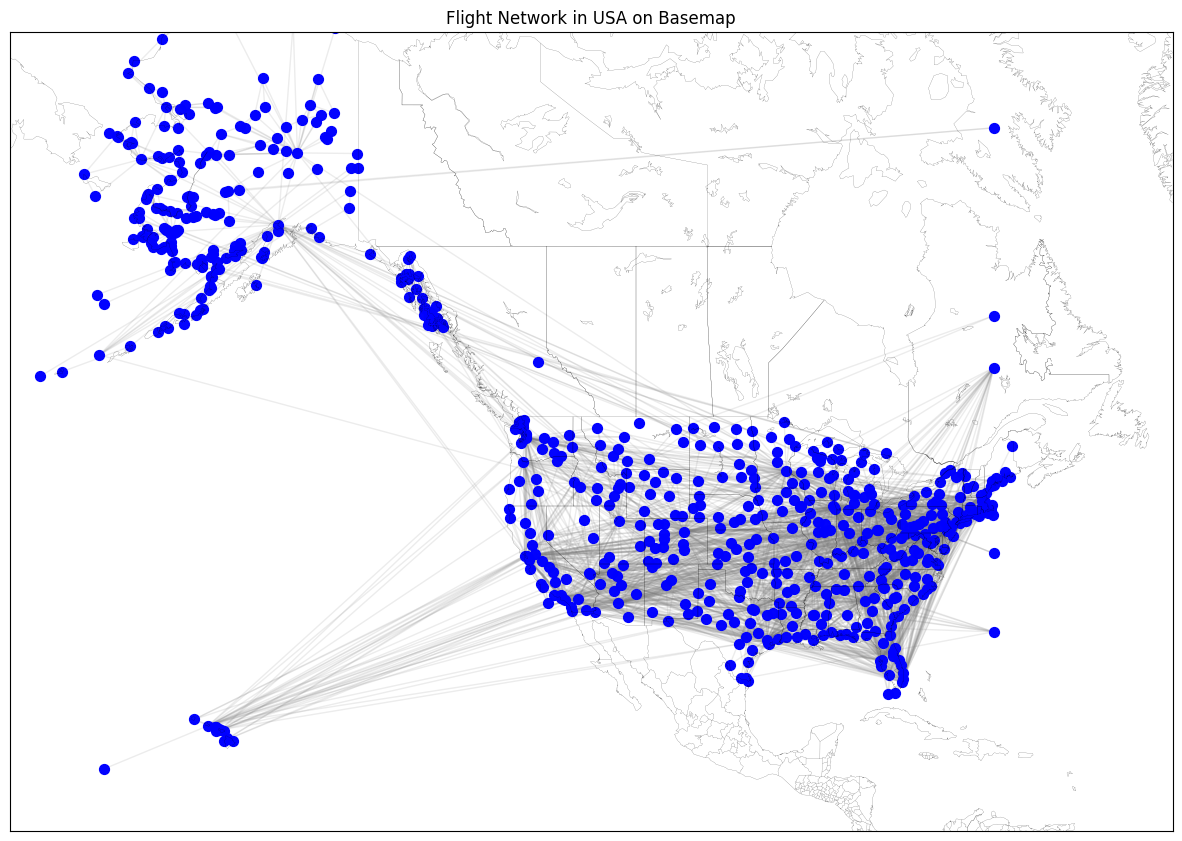

In [27]:
# Create Basemap network plots for each country
create_basemap_network_plot(cleaned_flights_data_corrected, "USA", *bounding_boxes["USA"],mode='simple')

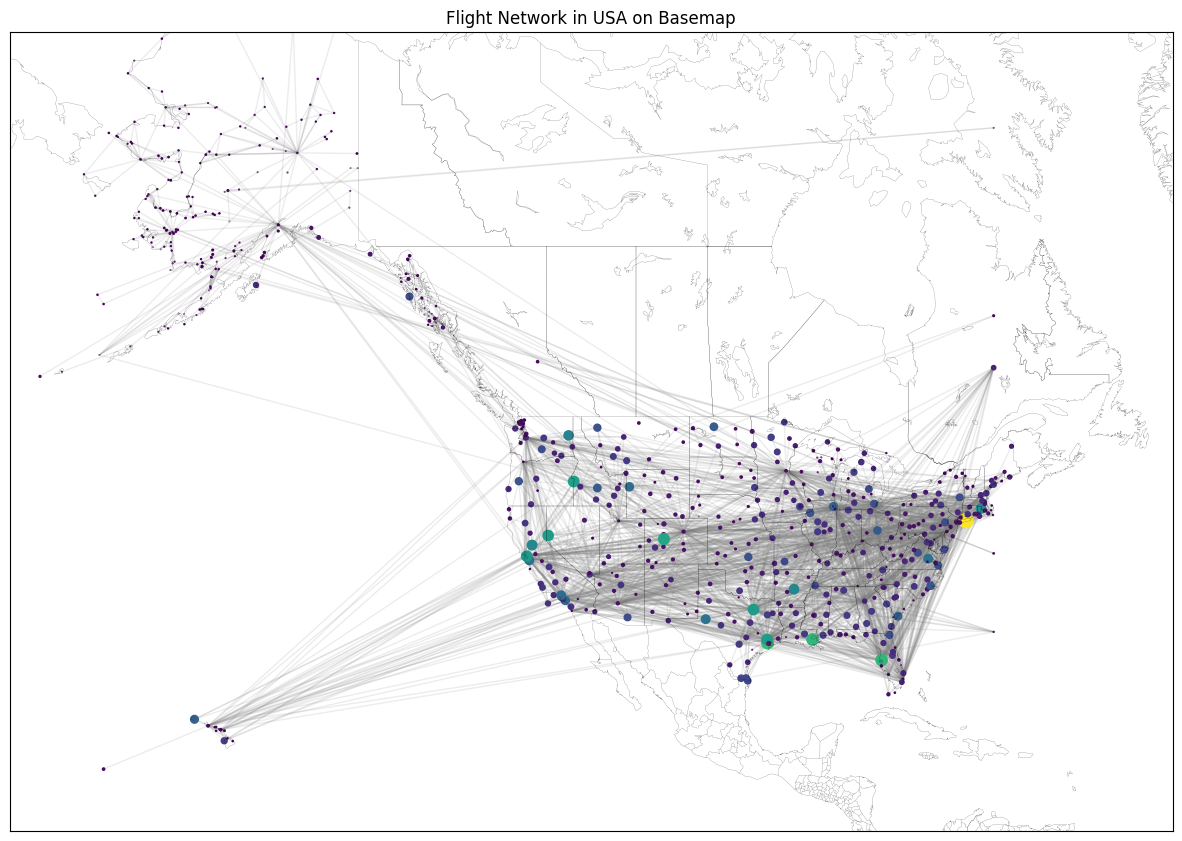

In [28]:
# Create Basemap network plots for each country
create_basemap_network_plot(cleaned_flights_data_corrected, "USA", *bounding_boxes["USA"],mode='advanced')

### Network Visualization Plots for Domestic Flights in UK